# Resultados - *Reddit* em português

Os testes a seguir foram realizados com o *corpus* em português de submissões do *Reddit* relacionadas à depressão.

3404 documentos de submissões foram utilizados para realização dos treinamentos dos modelos aqui avaliados. O conjunto foi coletado a partir do uso da API Pushshift e compreende postagens do período de 2008 a 2021 realizadas nos subreddits "desabafos" e "brasil". Como tais subreddits não são específicos ao tema de interesse - depressão - foi necessária uma busca mediada pelo uso de palavras-chave. Desta forma, o objetivo era delimitar as postagens a serem coletadas, de forma que apenas conteúdo relacionado a discussões sobre depressão fosse armazenado.

As seguintes palavras-chave foram usadas na coleta:
* "depressão"
* "suicídio"
* "diagnóstico depressão"
* "tratamento depressão"


Em seguida, uma etapa de pré-processamento do dataset e de preparação das entradas para cada um dos modelos foi realizada. As etapas de pré-processamento textual realizadas foram as seguintes, na ordem de listagem:

* remoção de \n e aspas simples
* tokenização de documentos
* lematização de documentos
* remoção de categorias de part-of-speech diferentes de substantivos (testes foram feitos utilizando substantivos, verbos e adjetivos, assim como somente substantivos e adjetivos, mas os resultados foram melhores apenas usando substantivos)
* remoção de stopwords
* remoção de termos infrequentes em documentos (freq. mín. = 1%, ou pelo menos 33 documentos do corpus)

Para as análises a seguir baseadas em embeddings de palavras os embeddings word2vec empregados no treinamento dos modelos ETM foram reutilizados. Esses embeddings são oriundos do projeto [Wikipedia2Vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/). Apenas embeddings de palavras foram considerados para a análise; dessa forma, os embeddings de entidades do Wikipedia2Vec foram ignorados.

### Importações e configurações de ambiente

In [1]:
%load_ext autoreload
%autoreload 2

from utils.plots import plot_wordcloud_by_word_probability, plot_coherence_by_k_graph, plot_tsne_graph_for_model, plot_lexical_categories_histogram
from utils.topics import get_word_probability_mappings
from utils.linguistic_inquiry_word_count import get_categories_for_word
from utils.notebook import get_coherence_score_for_each_topic, get_corpus_statistics
from utils.lexical_categories_analysis import get_liwc_categories_for_topics, get_raw_liwc_categories_for_topics
import sys, time, json, os, joblib, numpy as np, pandas as pd, ast
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

WORKDIR = os.getcwd()
EMBEDDINGS_PATH = f'{WORKDIR}/../../embeddings/'
MODELS_PATH = f'{WORKDIR}/models/'
CSVS_PATH = f'{WORKDIR}/csvs/'
RESOURCES_PATH = f'{WORKDIR}/resources/'
WORDS_PER_TOPIC = 20

# Arquivos
ORIGINAL_DATASET = f'{WORKDIR}/../../datasets/original/brasil_desabafos_2008_2021/reddit-posts-gatherer-pt.submissions_[without_duplicates].json'
PREPROCESSED_DATASET = f'{WORKDIR}/../../datasets/processed/reddit-posts-gatherer-noun/reddit-posts-gatherer-pt.submissions_noun[processed].json'
TEST_DATASET = f'{WORKDIR}/resources/test_documents.json'
DICTIONARY = f'{WORKDIR}/resources/word_dictionary.gdict'
WORD_LEMMA_MAPPING = f'{WORKDIR}/../../datasets/processed/reddit-posts-gatherer-noun/reddit-posts-gatherer-pt.submissions_noun[word_lemma_maps].json'
LIWC_DICTIONARY = f'{WORKDIR}/../../liwc/LIWC2007_Portugues_win.dic'

### Informações do dataset

In [3]:
original_data = json.load(open(ORIGINAL_DATASET, 'r'))
total_docs_orig, avg_no_of_tokens_orig_data, no_of_unique_tokens_orig_data = get_corpus_statistics(original_data)
print(f'Tamanho do dataset original (sem duplicatas): {total_docs_orig}')
print(f'Número médio de tokens por documento no dataset original: {avg_no_of_tokens_orig_data}')
print(f'Número de tokens únicos no dataset original: {no_of_unique_tokens_orig_data}')
preprocessed_data = json.load(open(PREPROCESSED_DATASET, 'r'))
print(f'Tamanho do dataset após pré-processamento: {len(preprocessed_data)}')

Tamanho do dataset original (sem duplicatas): 3404
Número médio de tokens por documento no dataset original: 370
Número de tokens únicos no dataset original: 81451
Tamanho do dataset após pré-processamento: 3394


### Resultados dos treinamentos de cada tipo de modelo

Nesta seção, avaliaremos os modelos CTM, ETM e LDA com maior valor para métrica de coerência quanto aos tópicos gerados pelos mesmos. A métrica de coerência NPMI é calculada após o treinamento de cada modelo, e emprega o dataset de teste para tal. 80% dos documentos foram utilizados para treino e os 20% restantes para o teste (cálculo de coerência).

Nesta seção, também será realizada a rotulação manual dos tópicos com significado mais claro.

As nuvens de palavras de cada tópico levam em consideração a probabilidade de cada palavra no seu respectivo tópico. Apenas as 20 palavras mais importantes de cada tópico serão usadas para as visualizações a seguir.

Na listagem dos modelos pelo total de coerência, apenas os 5 primeiros modelos serão exibidos.

#### CTM

Os modelos CTM tiveram resultados semelhantes entre si na métrica de coerência NPMI. O melhor colocado foi o CTM com 20 tópicos, portanto este será analisado abaixo.

In [20]:
ctm_results = pd.read_csv(CSVS_PATH + "ctm_combined_results.csv")
ctm_results_by_coherence = ctm_results.sort_values(["c_npmi_test"], ascending=(False))
ctm_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
6,6,20.0,ctm_k20_combined,-0.104791,-0.188456,0.402500,ctm/ctm_k20_combined,75.464190
9,9,28.0,ctm_k28_combined,-0.100893,-0.203868,0.373214,ctm/ctm_k28_combined,76.100783
2,2,10.0,ctm_k10_combined,-0.141462,-0.206100,0.480000,ctm/ctm_k10_combined,74.578925
8,8,25.0,ctm_k25_combined,-0.107023,-0.211983,0.374000,ctm/ctm_k25_combined,75.876350
4,4,15.0,ctm_k15_combined,-0.139718,-0.218820,0.416667,ctm/ctm_k15_combined,75.388322


#### ETM

O modelo ETM com melhor resultado foi aquele com 5 tópicos.

In [21]:
etm_results = pd.read_csv(CSVS_PATH + "etm_results.csv")
etm_results_by_coherence = etm_results.sort_values(["c_npmi_test"], ascending=(False))
etm_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
0,0,5.0,etm_k5,-0.009967,-0.025955,0.640000,etm/etm_k5,66.121439
1,1,8.0,etm_k8,-0.000296,-0.035100,0.675000,etm/etm_k8,66.568795
2,2,10.0,etm_k10,0.000563,-0.039160,0.595000,etm/etm_k10,66.166846
3,3,12.0,etm_k12,-0.000751,-0.043647,0.575000,etm/etm_k12,67.162926
4,4,15.0,etm_k15,-0.001664,-0.055317,0.516667,etm/etm_k15,66.922859


#### LDA

Os modelos LDA tiveram resultados semelhantes em termos de coerência àqueles obtidos pelos modelos ETM. O modelo LDA com melhor valor para a métrica de coerência foi aquele onde K=5, assim como no caso do ETM.

In [22]:
lda_results = pd.read_csv(CSVS_PATH + "lda_results.csv")
lda_results_by_coherence = lda_results.sort_values(["c_npmi_test"], ascending=(False))
lda_results_by_coherence.head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
0,0,5.0,lda_k5,-0.000516,-0.006473,0.350000,lda/lda_k5,6.027192
1,1,8.0,lda_k8,-0.004791,-0.017459,0.337500,lda/lda_k8,5.429506
2,2,10.0,lda_k10,-0.007966,-0.047824,0.430000,lda/lda_k10,5.168725
3,3,12.0,lda_k12,-0.012604,-0.059560,0.441667,lda/lda_k12,5.302516
4,4,15.0,lda_k15,-0.024290,-0.073969,0.453333,lda/lda_k15,5.485522


### Resultados de treinamento gerais

Unificando os resultados em CSV avaliados anteriormente, pode-se determinar o modelo com maior valor de coerência dentre todos aqueles treinados (LDA, CTM, ETM).

O modelo LDA com K=5 tópicos foi aquele que teve melhor resultado de coerência, seguido por outros modelos LDA e ETM.

In [23]:
df_geral = pd.concat([ctm_results, etm_results, lda_results], ignore_index=True)
df_geral.sort_values(["c_npmi_test"], ascending=(False)).head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
22,0,5.0,lda_k5,-0.000516,-0.006473,0.3500,lda/lda_k5,6.027192
23,1,8.0,lda_k8,-0.004791,-0.017459,0.3375,lda/lda_k8,5.429506
11,0,5.0,etm_k5,-0.009967,-0.025955,0.6400,etm/etm_k5,66.121439
12,1,8.0,etm_k8,-0.000296,-0.035100,0.6750,etm/etm_k8,66.568795
13,2,10.0,etm_k10,0.000563,-0.039160,0.5950,etm/etm_k10,66.166846


In [35]:
df_geral = pd.concat([ctm_results, etm_results, lda_results], ignore_index=True)
df_geral.sort_values(["c_npmi_train"], ascending=(False)).head()

,Unnamed: 0,k,model,c_npmi_train,c_npmi_test,diversity,path,train_time_in_seconds
13,2,10.0,etm_k10,0.000563,-0.039160,0.595000,etm/etm_k10,66.166846
12,1,8.0,etm_k8,-0.000296,-0.035100,0.675000,etm/etm_k8,66.568795
22,0,5.0,lda_k5,-0.000516,-0.006473,0.350000,lda/lda_k5,6.027192
14,3,12.0,etm_k12,-0.000751,-0.043647,0.575000,etm/etm_k12,67.162926
15,4,15.0,etm_k15,-0.001664,-0.055317,0.516667,etm/etm_k15,66.922859


O gráfico a seguir mostra a variação de coerência nos modelos treinados, conforme aumenta-se o valor de K. Percebe-se que os modelos LDA e ETM tiveram coerência superior aos modelos CTM em todos os cenários produzidos. Além disso, nota-se que o valor de coerência desce nos modelos LDA/ETM à medida que o número de tópicos aumenta.

Os resultados visíveis no gráfico condizem com os termos observados nos tópicos dos modelos de melhor resultado em cada um dos três tipos. Enquanto no modelo CTM alguns tópicos parecem se repetir, nos modelos LDA e ETM os tópicos aparecem apenas uma vez. Isso demonstra a melhor qualidade atingida pelos modelos LDA e ETM nos cenários avaliados.

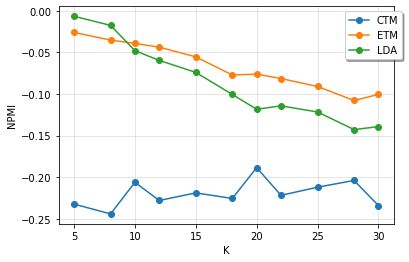

In [24]:
graph_data = [{ 'x': csv['k'], 'y': csv['c_npmi_test'] } for csv in [ctm_results, etm_results, lda_results]]
plot_coherence_by_k_graph(graph_data, ['CTM', 'ETM', 'LDA'])

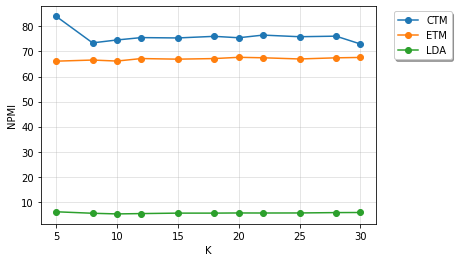

In [25]:
graph_data = [{ 'x': csv['k'], 'y': csv['train_time_in_seconds'] } for csv in [ctm_results, etm_results, lda_results]]
plot_coherence_by_k_graph(graph_data, ['CTM', 'ETM', 'LDA'])

### Explorando o melhor modelo: LDA com 5 tópicos

In [26]:
test_docs = json.load(open(TEST_DATASET, "r"))["split"]
dictionary = joblib.load(DICTIONARY)

Tópico 0 - pai casar vidar ano coisa mae pessoa familia dia empregar irmao filho vezar irma trabalhar caro dinheiro filhar causar entao


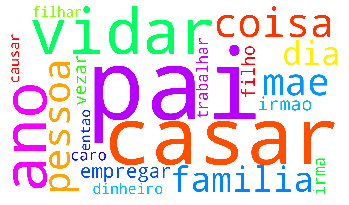

Tópico 1 - ano pai faculdade dinheiro casar cursar dia trabalhar empresar cidade partir area escola problema aula tempo professorar mundo contar horar


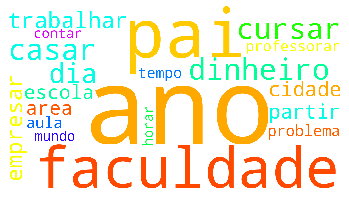

Tópico 2 - vidar dia ansiedade coisa ano tempo problema tratamento ajudar pessoa vezar sentir crise remedios terapia vontade formar psiquiatro mês efeito


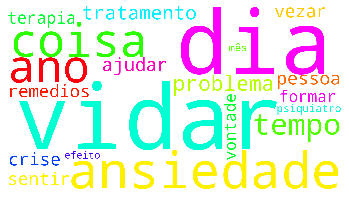

Tópico 3 - ano dia coisa amigo tempo vidar pessoa gente casar namorar problema amigar vezar entao vez caro atar mês semana escola


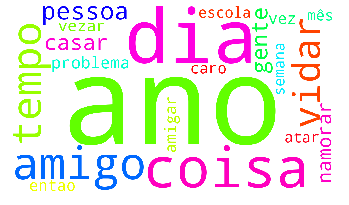

Tópico 4 - pessoa vidar coisa tempo mundo suicidio problema formar vezar dia sentir momento partir gente amigo tipo medo verdade caro atar


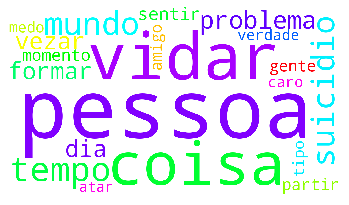

In [27]:
lda_best_model_path = lda_results_by_coherence['path'].tolist()[0]
lda1 = joblib.load(os.path.join(MODELS_PATH, lda_best_model_path))

lda_topics_probs = [topic[:WORDS_PER_TOPIC] for topic in lda1['topics_with_word_probs']]
lda_mapping = get_word_probability_mappings(lda_topics_probs)
coherence_by_topic = get_coherence_score_for_each_topic(lda1["topics"], test_docs, dictionary)

for idx, mapping in enumerate(lda_mapping):
    print(f'Tópico {idx} - {" ".join(lda1["topics"][idx])}')
    plot_wordcloud_by_word_probability(lda_mapping[idx], f'lda_topic={idx+1}')

#### Tópicos

Tópico 0: família<br>
1: estudos / vida profissional<br>
2: rotina de problemas mentais<br>
3: -<br>
4: -<br>

In [28]:
topics_coherence_table = pd.DataFrame(coherence_by_topic, columns=["npmi"])
topics_coherence_table.sort_values(["npmi"], ascending=(False))

,npmi
0,-0.002456
2,-0.004057
3,-0.004769
1,-0.005065
4,-0.016018


### Distribuição espacial dos tópicos do modelo com melhor coerência usando t-SNE

Nesta seção, os modelos CTM, ETM e LDA acima discutidos serão avaliados quanto à sua distribuição espacial.

Para tal, os embeddings Wikipedia2Vec foram utilizados para obter a representação vetorial de cada termo dos tópicos obtidos nos três modelos. Como os termos do vocabulário sofreram lematização, nem sempre eles serão encontrados em sua forma lematizada dentro do conjunto de embeddings. Neste caso, um mapeamento auxiliar entre lemas e termos originais foi utilizado. Este mapeamento indica quais termos foram substituídos por um determinado lema no vocabulário. Quando um lema não é encontrado nos embeddings, verifica-se caso algum dos termos substituídos pelo lema existe nos embeddings. Se existir, o vetor do lema será o mesmo vetor da palavra encontrada.

Caso nenhum dos termos substituídos seja encontrado nos embeddings, o termo é desconsiderado na obtenção de vetores.

Obtidos os vetores de palavras de um tópico, pode-se realizar uma exibição dos mesmos em um espaço vetorial. Como originalmente os embeddings têm 300 dimensões, é preciso realizar redução de dimensionalidade dos vetores. Com esse intuito, foi emprego o algoritmo t-SNE, utilizado para reduzir as 300 dimensões em 2, facilitando a exibição gráfica dos tópicos por meio de um simples gráfico bidimensional.

O procedimento descrito foi realizado para cada um dos tópicos dos modelos treinados e está por trás das visualizações exibidas adiante. Além disso, o peso de cada palavra em cada tópico também foi considerado nesta etapa, definindo o tamanho dos pontos relativos a palavras exibidos nos gráficos. Quanto maior o ponto, maior a importância de um dado termo no tópico associado. Contudo, como as probabilidades variam em margens pequenas entre si, as diferenças de tamanho entre os pontos são difíceis de serem notadas.

#### LDA

A figura a seguir exibe a visualização gráfica dos modelo LDA com melhor coerência, onde K=5 tópicos.

In [29]:
#plot_tsne_graph_for_model(lda1, "LDA_K=5")

### Termos presentes no LIWC em português mais parecidos com os vetores de tópicos

A etapa anterior de obtenção dos vetores de palavras de um tópico auxiliou na análise a seguir. A ideia neste momento é determinar quais os termos do dicionário LIWC em português são mais parecidos com cada um dos tópicos. Dessa forma, pode-se determinar quais categorias semânticas do LIWC estão associadas a cada tópico.

Com esse objetivo e de posse dos vetores de palavras, um vetor para cada tópico foi calculado. O vetor de tópico é obtido a partir da média ponderada dos vetores de palavras constituintes do tópico em questão. A média ponderada leva em consideração a importância de cada palavra dentro do tópico, por meio das probabilidades associadas a cada termo do tópico.

Em seguida, o embedding do tópico foi usado para determinar os termos mais parecidos com o mesmo por meio da API ```KeyedVectors``` da biblioteca *gensim*. Contudo, apenas termos do conjunto de embeddings que também existiam no dicionário LIWC em língua portuguesa foram considerados nesta comparação. Isto pois, em testes preliminares, frequentemente o termo mais parecido com o tópico não existia no dicionário LIWC.

Finalmente, o termo mais parecido com o tópico é assim determinado e suas categorias semânticas extraídas usando o LIWC. Os resultados obtidos são dados abaixo.

#### LDA

Os termos mais parecidos com cada tópico do modelo com K=5 do LDA são mostrados a seguir. As categorias do LIWC associadas ao termo também são exibidas.

In [30]:
for idx, topic_arr in enumerate(lda1["topics"]):
    print(f'Tópico {idx+1}: {", ".join(topic_arr)}\nTermos semelhantes: {lda1["most_similar_words"][idx][:3]}\n\n')

Tópico 1: pai, casar, vidar, ano, coisa, mae, pessoa, familia, dia, empregar, irmao, filho, vezar, irma, trabalhar, caro, dinheiro, filhar, causar, entao
Termos semelhantes: [('pai', 0.8024599552154541), ('chorasse', 0.7391000986099243), ('marido', 0.7378188371658325)]


Tópico 2: ano, pai, faculdade, dinheiro, casar, cursar, dia, trabalhar, empresar, cidade, partir, area, escola, problema, aula, tempo, professorar, mundo, contar, horar
Termos semelhantes: [('marçano', 0.7260373830795288), ('expulsada', 0.7243770360946655), ('deteriorarem', 0.7166702747344971)]


Tópico 3: vidar, dia, ansiedade, coisa, ano, tempo, problema, tratamento, ajudar, pessoa, vezar, sentir, crise, remedios, terapia, vontade, formar, psiquiatro, mês, efeito
Termos semelhantes: [('sexofobia', 0.7690659761428833), ('celebro', 0.7480087280273438), ('presumiria', 0.7478752136230469)]


Tópico 4: ano, dia, coisa, amigo, tempo, vidar, pessoa, gente, casar, namorar, problema, amigar, vezar, entao, vez, caro, atar, mês

In [31]:
for idx, word_similarity_pair in enumerate(lda1["most_similar_words"]):
    word = word_similarity_pair[0][0]
    print(f'Tópico {idx+1} - "{word}" - Categorias: {get_categories_for_word(word, LIWC_DICTIONARY)}\n')

Tópico 1 - "pai" - Categorias: ['swear', 'social', 'family']

Tópico 2 - "marçano" - Categorias: ['space']

Tópico 3 - "sexofobia" - Categorias: ['bio', 'sexual']

Tópico 4 - "viajarei" - Categorias: ['relativ', 'motion']

Tópico 5 - "pessoa" - Categorias: ['social', 'humans', 'time']



### Categorias LIWC dos termos presentes nos tópicos extraídos

#### LDA

In [32]:
counts = get_liwc_categories_for_topics(lda1, LIWC_DICTIONARY, normalize=True)
print(f'Categorias encontradas: {len(counts)}')

Categorias encontradas: 36


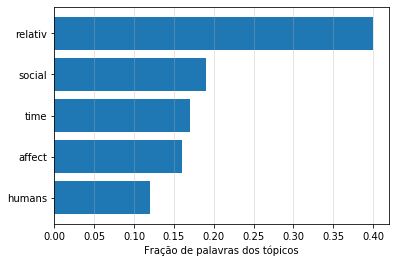

In [33]:
plot_lexical_categories_histogram(counts, topn=5)

relativ = relatividade, exemplos: area, bend, exit, stop <br>
social = processos sociais, exemplos: mate, talk, they, child<br>
time = tempo, exemplos: end, until, season <br>
affect = processos afetivos, exemplos: happy, cried, abandon <br>
humans = humanos, exemplo: adulto, baby, boy <br>
swear = xingamentos/termos chulos, exemplos: damn, piss, fuck <br>
funct = palavras funcionais (pronomes pessoais e impessoais), exemplos: i, them, itself, me, we, our <br>
cogmech = processos cognitivos, exemplo: cause, know, ought <br>
percept = processos de perpcepção, exemplo: observing, heard, feeling <br>
ingest = ingestão, exemplo: dish, eat, pizza <br>

In [34]:
get_raw_liwc_categories_for_topics(lda1, LIWC_DICTIONARY)

[{'pai': ['swear', 'social', 'family'],
  'casar': ['funct', 'social', 'friend'],
  'vidar': [],
  'ano': ['relativ', 'time'],
  'coisa': ['funct', 'pronoun', 'ipron', 'swear'],
  'mae': [],
  'pessoa': ['social', 'humans', 'time'],
  'familia': ['swear'],
  'dia': ['ingest', 'relativ', 'time'],
  'empregar': ['time', 'work'],
  'irmao': [],
  'filho': ['swear', 'social', 'family', 'humans', 'percept', 'bio'],
  'vezar': ['relativ'],
  'irma': [],
  'trabalhar': ['funct',
   'auxverb',
   'past',
   'verb',
   'relativ',
   'motion',
   'work',
   'achieve'],
  'caro': ['social',
   'humans',
   'affect',
   'posemo',
   'percept',
   'relativ',
   'money'],
  'dinheiro': ['money'],
  'filhar': [],
  'causar': ['cogmech', 'insight', 'relativ'],
  'entao': []},
 {'ano': ['relativ', 'time'],
  'pai': ['swear', 'social', 'family'],
  'faculdade': ['work'],
  'dinheiro': ['money'],
  'casar': ['funct', 'social', 'friend'],
  'cursar': [],
  'dia': ['ingest', 'relativ', 'time'],
  'trabalha